## **ФИО:** Цыбулько Даниил Викторович
## **Группа:** М8О-208Б-22

In [255]:
!pip install pmdarima

In [256]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

## Загружаем данные

In [257]:
!wget https://raw.githubusercontent.com/DaniilTsybulko/ML_Labs_MAI/refs/heads/main/lab3/tstest.csv

--2025-01-09 18:01:48--  https://raw.githubusercontent.com/DaniilTsybulko/ML_Labs_MAI/refs/heads/main/lab3/tstest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7843 (7.7K) [text/plain]
Saving to: ‘tstest.csv.12’

tstest.csv.12       100%[===================>]   7.66K  --.-KB/s    in 0s      

2025-01-09 18:01:48 (82.3 MB/s) - ‘tstest.csv.12’ saved [7843/7843]



In [258]:
!wget https://raw.githubusercontent.com/DaniilTsybulko/ML_Labs_MAI/refs/heads/main/lab3/tstrain.csv

--2025-01-09 18:01:48--  https://raw.githubusercontent.com/DaniilTsybulko/ML_Labs_MAI/refs/heads/main/lab3/tstrain.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335087 (327K) [text/plain]
Saving to: ‘tstrain.csv.12’

tstrain.csv.12      100%[===================>] 327.23K  --.-KB/s    in 0.005s  

2025-01-09 18:01:48 (61.2 MB/s) - ‘tstrain.csv.12’ saved [335087/335087]



In [259]:
train = pd.read_csv("tstrain.csv")
test = pd.read_csv("tstest.csv")

In [260]:
test

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment
0,1,2012-10-19,67.97,3.594,223.425723,6.573
1,1,2012-10-26,69.16,3.506,223.444251,6.573
2,1,2012-11-05,73.77,3.688,221.725663,7.143
3,1,2012-12-10,62.99,3.601,223.381296,6.573
4,2,2012-10-19,68.08,3.594,223.059808,6.170
...,...,...,...,...,...,...
175,44,2012-12-10,55.10,3.797,131.108333,5.217
176,45,2012-10-19,56.47,3.969,192.330854,8.667
177,45,2012-10-26,58.85,3.882,192.308899,8.667
178,45,2012-11-05,61.24,3.889,190.976417,8.567


In [261]:
train

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-01-10,1453329.50,71.89,2.603,211.671989,7.838
1,1,2010-02-04,1594968.28,62.27,2.719,210.820450,7.808
2,1,2010-02-07,1492418.14,80.91,2.669,211.223533,7.787
3,1,2010-02-19,1611968.17,39.93,2.514,211.289143,8.106
4,1,2010-02-26,1409727.59,46.63,2.561,211.319643,8.106
...,...,...,...,...,...,...,...
6250,45,2012-09-14,702238.27,67.87,3.948,191.699850,8.684
6251,45,2012-09-21,723086.20,65.32,4.038,191.856704,8.684
6252,45,2012-09-28,713173.95,64.88,3.997,192.013558,8.684
6253,45,2012-10-02,803657.12,37.00,3.640,189.707605,8.424


## Смотрим различные графики для Store 1

In [262]:
store_sample = train[train['Store'] == 1]

In [268]:
plt.figure(figsize=(18, 15))

<Figure size 1800x1500 with 0 Axes>

<Figure size 1800x1500 with 0 Axes>

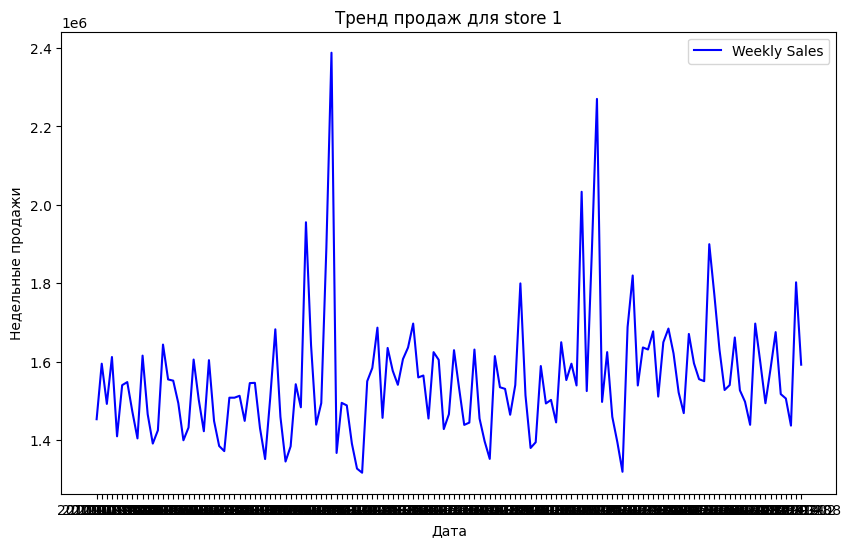

In [271]:
plt.figure(figsize=(10, 6))
plt.plot(store_sample['Date'], store_sample['Weekly_Sales'], label='Weekly Sales', color='blue')
plt.title('Тренд продаж для store 1')
plt.xlabel('Дата')
plt.ylabel('Недельные продажи')
plt.legend()

Text(0, 0.5, 'Недельные продажи')

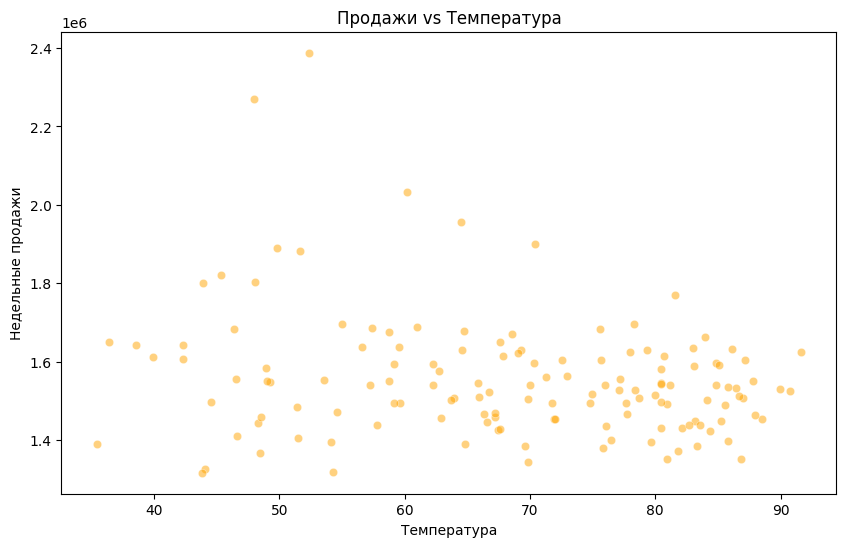

In [273]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=store_sample, x='Temperature', y='Weekly_Sales', alpha=0.5, color='orange')
plt.title('Продажи vs Температура')
plt.xlabel('Температура')
plt.ylabel('Недельные продажи')

Text(0, 0.5, 'Недельные продажи')

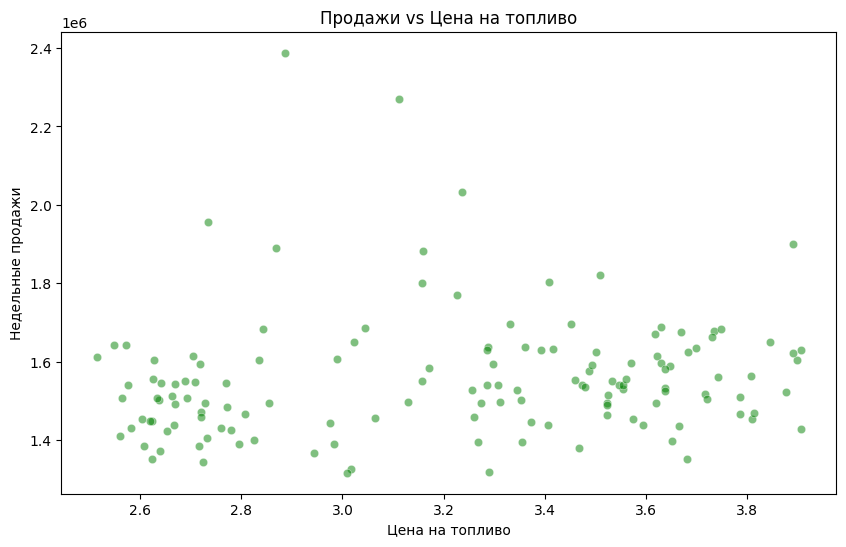

In [274]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=store_sample, x='Fuel_Price', y='Weekly_Sales', alpha=0.5, color='green')
plt.title('Продажи vs Цена на топливо')
plt.xlabel('Цена на топливо')
plt.ylabel('Недельные продажи')

## Делаем новые фичи

In [234]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Date          6255 non-null   object 
 2   Weekly_Sales  6255 non-null   float64
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   CPI           6255 non-null   float64
 6   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 342.2+ KB


In [235]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         180 non-null    int64  
 1   Date          180 non-null    object 
 2   Temperature   180 non-null    float64
 3   Fuel_Price    180 non-null    float64
 4   CPI           180 non-null    float64
 5   Unemployment  180 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 8.6+ KB


In [236]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [237]:
def create_time_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)
    df['Week_sin'] = np.sin(2 * np.pi * df['Week']/52)
    df['Week_cos'] = np.cos(2 * np.pi * df['Week']/52)

    return df

In [238]:
train = create_time_features(train)
test = create_time_features(test)

In [239]:
train = train.dropna()

In [240]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6255 non-null   int64         
 1   Date          6255 non-null   datetime64[ns]
 2   Weekly_Sales  6255 non-null   float64       
 3   Temperature   6255 non-null   float64       
 4   Fuel_Price    6255 non-null   float64       
 5   CPI           6255 non-null   float64       
 6   Unemployment  6255 non-null   float64       
 7   Year          6255 non-null   int32         
 8   Month         6255 non-null   int32         
 9   Week          6255 non-null   int64         
 10  DayOfWeek     6255 non-null   int32         
 11  Quarter       6255 non-null   int32         
 12  DayOfYear     6255 non-null   int32         
 13  WeekOfYear    6255 non-null   int64         
 14  Month_sin     6255 non-null   float64       
 15  Month_cos     6255 non-null   float64 

In [241]:
train["Store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

## Делим наши датасеты на количество магазинов

In [242]:
df_by_store = {}

unique_stores = train["Store"].unique()

for store in unique_stores:
    df_by_store[store] = train[train["Store"] == store]
    df_by_store[store].set_index('Date', inplace=True)

In [243]:
test_df_by_store = {}

unique_stores = test["Store"].unique()

for store in unique_stores:
    test_df_by_store[store] = test[test["Store"] == store]
    test_df_by_store[store].set_index('Date', inplace=True)

In [244]:
df_by_store[1]

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,DayOfWeek,Quarter,DayOfYear,WeekOfYear,Month_sin,Month_cos,Week_sin,Week_cos
Date,,,,,,,,,,,,,,,,,
2010-01-10,1,1453329.50,71.89,2.603,211.671989,7.838,2010,1,1,6,1,10,1,0.500000,8.660254e-01,0.120537,9.927089e-01
2010-02-04,1,1594968.28,62.27,2.719,210.820450,7.808,2010,2,5,3,1,35,5,0.866025,5.000000e-01,0.568065,8.229839e-01
2010-02-07,1,1492418.14,80.91,2.669,211.223533,7.787,2010,2,5,6,1,38,5,0.866025,5.000000e-01,0.568065,8.229839e-01
2010-02-19,1,1611968.17,39.93,2.514,211.289143,8.106,2010,2,7,4,1,50,7,0.866025,5.000000e-01,0.748511,6.631227e-01
2010-02-26,1,1409727.59,46.63,2.561,211.319643,8.106,2010,2,8,4,1,57,8,0.866025,5.000000e-01,0.822984,5.680647e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-14,1,1517428.87,74.97,3.717,222.582019,6.908,2012,9,37,4,3,258,37,-1.000000,-1.836970e-16,-0.970942,-2.393157e-01
2012-09-21,1,1506126.06,69.87,3.721,222.781839,6.908,2012,9,38,4,3,265,38,-1.000000,-1.836970e-16,-0.992709,-1.205367e-01
2012-09-28,1,1437059.26,76.08,3.666,222.981658,6.908,2012,9,39,4,3,272,39,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16


In [245]:
df_by_store[1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 2010-01-10 to 2012-10-08
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         139 non-null    int64  
 1   Weekly_Sales  139 non-null    float64
 2   Temperature   139 non-null    float64
 3   Fuel_Price    139 non-null    float64
 4   CPI           139 non-null    float64
 5   Unemployment  139 non-null    float64
 6   Year          139 non-null    int32  
 7   Month         139 non-null    int32  
 8   Week          139 non-null    int64  
 9   DayOfWeek     139 non-null    int32  
 10  Quarter       139 non-null    int32  
 11  DayOfYear     139 non-null    int32  
 12  WeekOfYear    139 non-null    int64  
 13  Month_sin     139 non-null    float64
 14  Month_cos     139 non-null    float64
 15  Week_sin      139 non-null    float64
 16  Week_cos      139 non-null    float64
dtypes: float64(9), int32(5), int64(3)
memory usage: 16.8 K

## Делим обучающую выборку на train и test, чтобы посомтреть метрики, и обучаем сначала auto arima, а потом используем ее гиперпараметры для SARIMAX

In [246]:
train = df_by_store[42].iloc[:-6]
test = df_by_store[42].iloc[-6:]

In [247]:
train = df_by_store[42].iloc[:-6]
test = df_by_store[42].iloc[-6:]

train_exog = train[["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week",
                    "DayOfWeek", "Quarter", "DayOfYear", "WeekOfYear", "Month_sin", "Month_cos",
                    "Week_sin", "Week_cos"]]
test_exog = test[["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week",
                  "DayOfWeek", "Quarter", "DayOfYear", "WeekOfYear", "Month_sin", "Month_cos",
                  "Week_sin", "Week_cos"]]

y_train = train["Weekly_Sales"].astype(float)
y_test = test["Weekly_Sales"].astype(float)

auto_model = auto_arima(
    y_train,
    exogenous=train_exog,
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)

print("Подобранные параметры auto_arima:", auto_model.get_params())

model_sarimax = SARIMAX(
    y_train,
    exog=train_exog,
    order=auto_model.order,
    seasonal_order=auto_model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

sarimax_fit = model_sarimax.fit()

forecast_sarimax = sarimax_fit.forecast(steps=len(y_test), exog=test_exog)

mape_sarimax = mean_absolute_percentage_error(y_test, forecast_sarimax)
print("MAPE для SARIMAX:", mape_sarimax)


Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3254.616, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3282.238, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3282.666, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3267.286, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3280.243, Time=0.02 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3252.624, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3251.323, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3252.616, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3251.022, Time=0.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=3252.543, Time=0.22 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=3252.430, Time=0.22 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=3254.305, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=3249.504, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=3251.063, Time=0.15 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=3250.901, Time=0.16 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=3252.635, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3266.355, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=3251.525, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3258.895, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=3253.228, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12]             : AIC=3248.317, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[12]             : AIC=3249.673, Time=0.40 sec
 ARIMA(0,1,2)(0,0,1)[12]             : AIC=3249.683, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12]             : AIC=3251.673, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=3265.536, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12]             : AIC=3250.111, Time=0.26 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[12]             : AIC=3250.236, Time=0.74 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12]             : AIC=3258.214, Time=0.68 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[12]             : AIC=3252.883, Time=0.44 sec

Best model:  ARIMA(0,1,2)(0,0,0)[12]          
Total fit time: 7.202 seconds
Подобранные параметры auto_arima: {'maxiter': 50, 'method': 'lbfgs', 'order': (0, 1, 2), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 12), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MAPE для SARIMAX: 0.037183385361292565


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


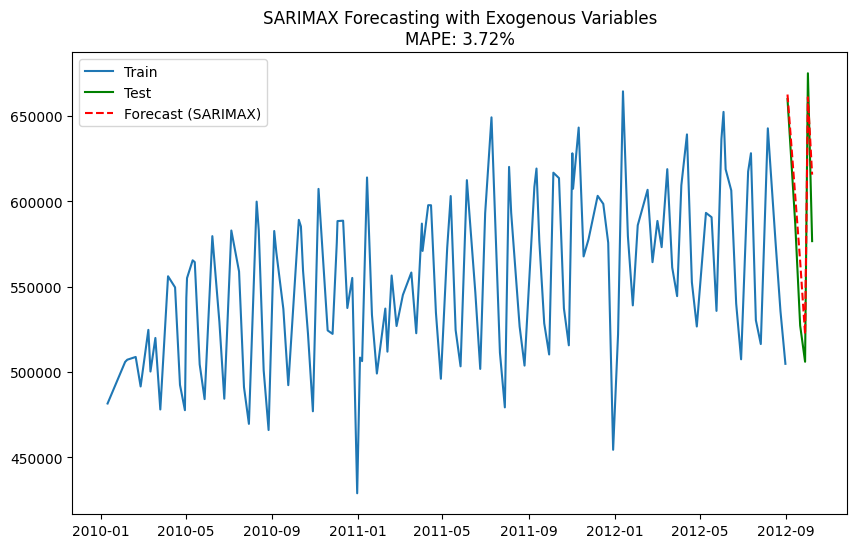

In [248]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train["Weekly_Sales"], label="Train")
plt.plot(test.index, test["Weekly_Sales"], label="Test", color="green")
plt.plot(test.index, forecast_sarimax, label="Forecast (SARIMAX)", color="red", linestyle="--")
plt.legend()
plt.title(f"SARIMAX Forecasting with Exogenous Variables\nMAPE: {mape_sarimax:.2%}")
plt.show()

## Обучаем SARIMAX на всей обучающей выборке и создаем сабмит файл

In [249]:
sarimax_test = []
for i in range(1, 46):
  train = df_by_store[i]
  test = test_df_by_store[i]
  train_exog = df_by_store[i][["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week", "DayOfWeek", "Quarter", "DayOfYear", "WeekOfYear", "Month_sin", "Month_cos", "Week_sin", "Week_cos"]]
  test_exog = test_df_by_store[i][["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week", "DayOfWeek", "Quarter", "DayOfYear", "WeekOfYear", "Month_sin", "Month_cos", "Week_sin", "Week_cos"]]

  model = SARIMAX(
    train["Weekly_Sales"],
    exog=train_exog,
    maxiter= 50,
    method= 'lbfgs',
    out_of_sample_size= 0,
    start_params= None,
    suppress_warnings= True,
    trend= None,
    with_intercept= False,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
  )
  sarimax_fit = model.fit()

  forecast_sarimax = sarimax_fit.forecast(steps=len(test), exog=test_exog)
  sarimax_test.append(forecast_sarimax)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter', 'method', 'out_of_sample_size', 'start_params', 'suppress_warnings', 'with_intercept']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction r

In [250]:
submit_data = []

for i, forecast in enumerate(sarimax_test, start=1):
    test_store = test_df_by_store[i]

    store_forecast = pd.DataFrame({
        "Weekly_Sales": forecast.values,
    })

    submit_data.append(store_forecast)

submit_df = pd.concat(submit_data, ignore_index=True)

submit_df["ID"] = submit_df.index

submit_df = submit_df[["ID", "Weekly_Sales"]]

submit_df.to_csv("s-ubmission.csv", index=False)

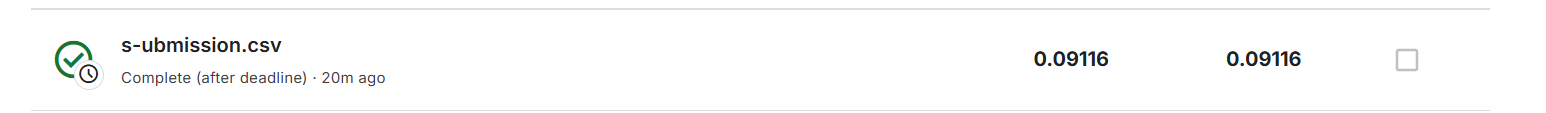